In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install shapely
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install firebase-admin
!pip install google-cloud-storage

print("Install complete.")




[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Install complete.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path
import firebase_admin
from firebase_admin import credentials, firestore

# Read log files
robomaker_log = 'training-20231025054613-mn9FtA0wRniBWRRedOOrVw-robomaker.log'
sagemaker_log = 'training-20231025054611-mn9FtA0wRniBWRRedOOrVw-sagemaker.log'

# Verify log files have been read
with open(robomaker_log, 'r') as file:
    print("Robomaker log file read.")

with open(sagemaker_log, 'r') as file:
      print("sagemaker log file read.")



# Initialize Firebase
if not firebase_admin._apps:
    cred = credentials.Certificate("deepracer-52ec7-firebase-adminsdk-z1mqa-0560f04062.json")
    firebase_admin.initialize_app(cred)
else:
    print("Firebase app already initialized.")

# Initialize Firestore DB
db = firestore.client()

# Add a sample document to a collection named 'test_collection'
doc_ref = db.collection('test_collection').add({'status': 'connected'})

# Read the document back
doc = db.collection('test_collection').document(doc_ref[1].id).get()

# Print the 'status' field to confirm connection
print('Firestore Connection Status:', doc.to_dict()['status'])



Robomaker log file read.
sagemaker log file read.
Firestore Connection Status: connected


NotFound: 404 GET https://storage.googleapis.com/storage/v1/b/your-firebase-bucket-name?projection=noAcl&prettyPrint=false: The specified bucket does not exist.

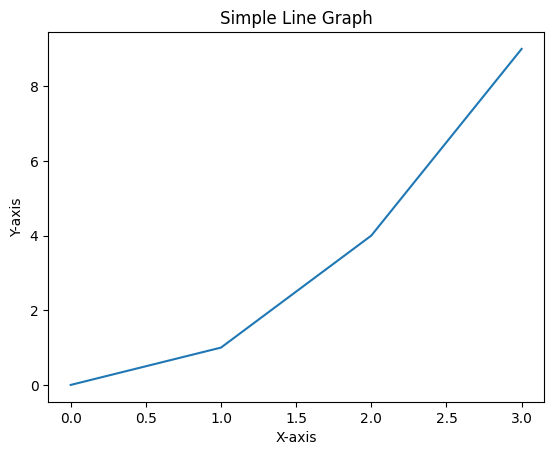

In [3]:
from google.cloud import storage
import matplotlib.pyplot as plt
import uuid

# Create a simple line graph
plt.plot([0, 1, 2, 3], [0, 1, 4, 9])
plt.title("Simple Line Graph")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Save it as an image
image_filename = f"line_graph_{uuid.uuid4()}.png"
plt.savefig(image_filename)

# Initialize Google Cloud Storage client
storage_client = storage.Client.from_service_account_json("deepracer-52ec7-firebase-adminsdk-z1mqa-0560f04062.json")

# Get your Firebase Storage bucket
bucket_name = "your-firebase-bucket-name"
bucket = storage_client.get_bucket(bucket_name)

# Upload the image to Firebase Storage
blob = bucket.blob(image_filename)
blob.upload_from_filename(image_filename)
print(f"Uploaded {image_filename} to Firebase Storage.")



In [4]:
# define Training Parameters


def robomaker_training_parameters(robomaker_log, training_parameters):
    parameters = {}
    
    with open(robomaker_log, 'r') as file:
        for line in file:
            if line.startswith("PARAMETERS"):
                break
                
        for line in file:
            if line.strip() == "":
                break
                
            try:
                parts = line.strip().split(": ")
                key = parts[0].strip(" *")
                if key in training_parameters:
                    parameters[key] = parts[1]
            except ValueError:
                continue
                
    return parameters
    #Retrieve

training_parameters_to_extract = [
    '/AWS_REGION', 
    '/WORLD_NAME', 
    '/SIMTRACE_S3_PREFIX', 
    '/MODEL_NAME',
    '/RACE_TYPE'
]

json_parameters = robomaker_training_parameters(robomaker_log, training_parameters_to_extract)

print(f"AWS_REGION: {json_parameters.get('/AWS_REGION', ' ')}")
print(f"WORLD_NAME: {json_parameters.get('/WORLD_NAME', ' ')}")
print(f"SIMTRACE_S3_PREFIX: {json_parameters.get('/SIMTRACE_S3_PREFIX', ' ')}")
print(f"MODEL_NAME: {json_parameters.get('/MODEL_NAME', ' ')}")
print(f"RACE_TYPE: {json_parameters.get('/RACE_TYPE', ' ')}")


AWS_REGION: us-east-1
WORLD_NAME: reInvent2019_trac...
SIMTRACE_S3_PREFIX: data-525c558b-419...
MODEL_NAME: JEN-DAS1
RACE_TYPE: TIME_TRIAL


In [5]:
 #define Hyperparameters

def robomaker_hyperparameters(robomaker_log, hyperparameter_data):
    hyperparameters = {}
    
    with open(robomaker_log, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None
    for i, line in enumerate(lines):
        if line.startswith("Using the following hyper-parameters"):
            start_index = i + 1
        elif start_index is not None and line.strip() == "}":
            end_index = i
            break

    if start_index is None or end_index is None:
        return hyperparameters
    
    json_block = "".join(lines[start_index:end_index+1]).strip()
    
    try:
        all_hyperparameters = json.loads(json_block)
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
        return hyperparameters
    
    for key in hyperparameter_data:
        hyperparameters[key] = all_hyperparameters.get(key, None)
    
    return hyperparameters

# Retrieve Hyperparameters

#EPI= episodes per iteration
hyperparameters = robomaker_hyperparameters(robomaker_log, ['num_episodes_between_training', 'num_epochs'])
EPI = int(hyperparameters.get('num_episodes_between_training', 0))
NUM_Epochs = int(hyperparameters.get('num_epochs', 0))

print('hyperparameters: %s' % hyperparameters)
print('EPI: %s' % EPI)
print('NUM_Epochs: %s' % NUM_Epochs)


#hyperparameter_data_to_extract = [
  #  "batch_size", 
 #   "num_episodes_between_training", 
  #  "num_epochs"
#]



#json_parameters = robomaker_hyperparameters(robomaker_log, hyperparameter_data_to_extract)
#
#print(f"Batch Size: {json_parameters.get('batch_size', ' ')}")
#print(f"Number of episodes: {json_parameters.get('num_episodes_between_training', ' ')}")
#print(f"Number of epochs: {json_parameters.get('num_epochs', ' ')}")

hyperparameters: {'num_episodes_between_training': 20, 'num_epochs': 10}
EPI: 20
NUM_Epochs: 10


In [6]:



def robomaker_action_space(robomaker_log):
    with open(robomaker_log, 'r') as file:
        for line in file:
            if "Action space from file:" in line:
                action_space_str = line.split("Action space from file:")[1].strip()
                action_space_str = action_space_str.replace("'", '"')
                action_space = json.loads(action_space_str)
                return action_space, 'simple'
                
            if "Reward Distribution Graph:  racecar" in line:
                action_space_str = line.split("Reward Distribution Graph:  racecar")[1].strip()
                action_space_str = action_space_str.replace("'", '"')
                action_space = json.loads(action_space_str)
                return action_space, 'advanced'
                
    print("Warning: No action space found.")
    return None, None

def display_action_space(action_space_data):
    if action_space_data is None:
        print("No action space data available.")
        return None
    
    # Check for 'index' to distinguish between Advanced and Simple Machines
    if all('index' in action for action in action_space_data):
        action_names = []
        for action in action_space_data:
            action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
            action_speed = ('SPD:%.2f' % action['speed'])
            action_names.append(action_steering + ' / ' + action_speed)
        return action_names
    
    else:  # For Simple Machines
        print("High:")
        for k, v in action_space_data.items():
            print(f"{k.capitalize()}: {v['high']}")
        
        print("\nLow:")
        for k, v in action_space_data.items():
            print(f"{k.capitalize()}: {v['low']}")
        return None


# Retrieve action space
action_space_data, machine_type = robomaker_action_space(robomaker_log)


# Display action space
result = display_action_space(action_space_data)
if result:
    for action in result:
        print(action)



RIGHT:30.0 / SPD:0.70
RIGHT:30.0 / SPD:1.70
RIGHT:30.0 / SPD:2.50
RIGHT:15.0 / SPD:0.70
RIGHT:15.0 / SPD:1.67
RIGHT:15.0 / SPD:2.50
CENTER:0.0 / SPD:0.70
CENTER:0.0 / SPD:1.67
CENTER:0.0 / SPD:2.50
LEFT:15.0 / SPD:0.70
LEFT:15.0 / SPD:1.67
LEFT:15.0 / SPD:2.50
LEFT:30.0 / SPD:0.70
LEFT:30.0 / SPD:1.67
LEFT:30.0 / SPD:2.50


In [7]:
def display_action_space_info(action_space_data, machine_type):
    if machine_type == 'advanced':
        speeds = [entry['speed'] for entry in action_space_data]
        angles = [entry['steering_angle'] for entry in action_space_data]
        
        print("SPEED:", speeds)
        print("STEERING:", angles)
        print("MIN SPEED:", min(speeds))
        print("MAX SPEED:", max(speeds))
        print("MIN STEERING:", min(angles))
        print("MAX STEERING:", max(angles))
        print("SPEED RANGE:", max(speeds) - min(speeds))
        print("STEERING RANGE:", max(angles) - min(angles))
        
    elif machine_type == 'simple':
        speeds = [action_space_data['speed']['high'], action_space_data['speed']['low']]
        angles = [action_space_data['steering_angle']['high'], action_space_data['steering_angle']['low']]
        
        print("SPEED:", speeds)
        print("STEERING:", angles)

# Usage example
action_space_data, machine_type = robomaker_action_space(robomaker_log)
if action_space_data and machine_type:
    display_action_space_info(action_space_data, machine_type)
else:
    print("Failed to load action space data.")


TypeError: list indices must be integers or slices, not str

In [8]:
# Initialize list to store SIM_TRACE_LOG lines
sim_trace_logs = []

# Read the log file line by line
with open(robomaker_log, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            p = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_trace_logs.append(",".join(p))
            #sim_trace_logs.append(line.strip())  # Add line to the list after stripping newline characters

# Now you have the SIM_TRACE_LOG lines in the list `sim_trace_logs`
if sim_trace_logs:
    print("SIM_TRACE_LOG loded")
else:
    print(" SIM_TRACE_LOG data not found.")


SIM_TRACE_LOG loded


In [9]:
import pandas as pd

#raw sim table
# Reading the log file

df_list = list()

for t in sim_trace_logs[2:]:
    p = t.rstrip().split(",")
    episode = int(p[0])
    steps = int(p[1])
    x = 100*float(p[2])
    y = 100*float(p[3])
    yaw = float(p[4])
    steer = float(p[5])
    speed = float(p[6])
    action = float(p[7])
    reward = float(p[8])
    done = 0 if 'False' in p[9] else 1
    progress = float(p[11])
    closest_checkpoint = int(p[12])
    length = float(p[13])
    timestamp = float(p[14])
    stat = p[15]
    











    iteration = int(episode / EPI) + 1
    if (iteration ==1) and (episode ==0):
        steps -= 2
    episode_in_iteration = (episode % EPI) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, speed, action, reward, done, progress, closest_checkpoint, length, timestamp,  stat))
header = ['iteration', 'EPI(now working)', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'speed', 'action', 'reward', 'done', 'progress', 'closest_checkpoint', 'length', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df
    





,iteration,EPI(now working),episode,steps,x,y,yaw,steer,speed,action,reward,done,progress,closest_checkpoint,length,timestamp,status
0,1,1,1,1,-402.26,-16.48,-94.6914,0.0,0.70,6.0,2.000,0,0.6509,1,23.09,18.804,in_progress
1,1,1,1,2,-402.46,-18.91,-94.7797,30.0,2.50,14.0,2.000,0,0.7555,1,23.09,18.872,in_progress
2,1,1,1,3,-401.93,-22.46,-92.7761,0.0,1.67,7.0,2.000,0,0.9105,2,23.09,18.952,in_progress
3,1,1,1,4,-401.09,-27.02,-90.2437,0.0,2.50,8.0,2.000,0,1.1098,2,23.09,19.002,in_progress
4,1,1,1,5,-400.97,-32.46,-89.9027,15.0,0.70,9.0,2.000,0,1.3451,2,23.09,19.074,in_progress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14200,13,20,260,51,-195.15,-238.11,-31.8372,0.0,1.67,7.0,0.001,0,19.6644,13,23.09,1712.942,in_progress
14201,13,20,260,52,-188.11,-243.13,-33.0454,15.0,0.70,9.0,0.001,0,20.2262,13,23.09,1713.010,in_progress
14202,13,20,260,53,-177.18,-249.50,-31.7575,-30.0,0.70,0.0,0.001,0,20.6871,14,23.09,1713.094,in_progress
14203,13,20,260,54,-170.11,-253.21,-30.5434,-15.0,2.50,5.0,0.001,0,21.7678,14,23.09,1713.154,in_progress


In [10]:
#episode data

episode_sim_df = sim_df[sim_df["done"] == 1][["iteration", "EPI(now working)", "episode", "steps", "progress", "status"]].copy()
episode_sim_df["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
episode_sim_df["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
episode_sim_df["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
episode_sim_df["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")



episode_sim_df


,iteration,EPI(now working),episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
34,1,1,1,35,10.9071,off_track,39.404,2.268,18.804,21.072
73,1,2,2,39,15.3831,off_track,53.403,2.533,21.205,23.738
106,1,3,3,33,8.9662,off_track,37.104,2.132,23.873,26.005
128,1,4,4,22,5.2813,off_track,21.904,1.430,26.120,27.550
164,1,5,5,36,9.1945,off_track,32.309,2.329,27.672,30.001
...,...,...,...,...,...,...,...,...,...,...
13760,13,16,256,59,22.4416,off_track,52.104,3.867,1679.482,1683.349
13821,13,17,257,61,16.7441,off_track,84.104,4.006,1683.486,1687.492
14085,13,18,258,264,99.7721,off_track,394.804,17.528,1687.617,1705.145
14149,13,19,259,64,28.3812,off_track,63.704,4.206,1705.276,1709.482


In [11]:
#iteration-related data

 

iteration_sim_df = episode_sim_df[episode_sim_df["EPI(now working)"] == 1][["iteration"]].copy()
iteration_sim_df["min_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("min")
iteration_sim_df["max_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("max")
iteration_sim_df["avg_progress"] = episode_sim_df.groupby("iteration")["progress"].transform("mean")
iteration_sim_df["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
iteration_sim_df["start_time"] = episode_sim_df.groupby("iteration")["start_time"].transform("min")
iteration_sim_df["end_time"] = episode_sim_df.groupby("iteration")["end_time"].transform("max")

iteration_sim_df


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time
34,1,2.9721,19.7721,7.945920,541.983,18.804,57.741
594,2,3.1968,15.5614,7.813900,626.776,82.066,119.475
1144,3,3.4493,26.8272,9.297655,616.182,135.670,177.199
1772,4,3.4435,32.1746,12.870450,736.685,196.687,249.737
2524,5,5.4338,36.4966,14.753250,906.910,325.204,386.880
3442,6,3.1063,29.5131,15.540650,1101.179,459.215,521.147
4349,7,3.7911,46.5935,19.124035,1198.307,578.482,653.743
5454,8,2.6547,32.4673,15.763200,1152.278,712.207,777.285
6411,9,10.6593,79.3658,28.447095,1840.576,850.744,952.418
7946,10,2.7905,48.4552,24.965280,1803.885,1041.604,1134.477


In [12]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from sklearn.preprocessing import MinMaxScaler

x = iteration_sim_df[['total_rewards']].values.astype(float)
if len(x) > 0:  # Missing parenthesis fixed
    min_max_scaler = MinMaxScaler(feature_range=(5, 95))
    x_scaled = min_max_scaler.fit_transform(x)
    iteration_sim_df['normalized_total_rewards'] = x_scaled

print('%d' % len(iteration_sim_df))

if len(iteration_sim_df) > 0:
    iteration_sim_df['normalized_total_rewards_SMA3'] = iteration_sim_df['normalized_total_rewards'].rolling(window=3).mean()
    iteration_sim_df['min_progress_SMA3'] = iteration_sim_df['min_progress'].rolling(window=3).mean()
    iteration_sim_df['max_progress_SMA3'] = iteration_sim_df['max_progress'].rolling(window=3).mean()
    iteration_sim_df['avg_progress_SMA3'] = iteration_sim_df['avg_progress'].rolling(window=3).mean()
    #iteration_sim_df['pct_completed_laps_SMA3'] = iteration_sim_df['pct_completed_laps'].rolling(window=3).mean()

iteration_sim_df


13


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time,normalized_total_rewards,normalized_total_rewards_SMA3,min_progress_SMA3,max_progress_SMA3,avg_progress_SMA3
34,1,2.9721,19.7721,7.945920,541.983,18.804,57.741,5.000000,NaN,NaN,NaN,NaN
594,2,3.1968,15.5614,7.813900,626.776,82.066,119.475,9.670661,NaN,NaN,NaN,NaN
1144,3,3.4493,26.8272,9.297655,616.182,135.670,177.199,9.087111,7.919257,3.206067,20.720233,8.352492
1772,4,3.4435,32.1746,12.870450,736.685,196.687,249.737,15.724790,11.494187,3.363200,24.854400,9.994002
2524,5,5.4338,36.4966,14.753250,906.910,325.204,386.880,25.101310,16.637737,4.108867,31.832800,12.307118
3442,6,3.1063,29.5131,15.540650,1101.179,459.215,521.147,35.802249,25.542783,3.994533,32.728100,14.388117
4349,7,3.7911,46.5935,19.124035,1198.307,578.482,653.743,41.152360,34.018640,4.110400,37.534400,16.472645
5454,8,2.6547,32.4673,15.763200,1152.278,712.207,777.285,38.616940,38.523849,3.184033,36.191300,16.809295
6411,9,10.6593,79.3658,28.447095,1840.576,850.744,952.418,76.530527,52.099942,5.701700,52.808867,21.111443
7946,10,2.7905,48.4552,24.965280,1803.885,1041.604,1134.477,74.509473,63.218980,5.368167,53.429433,23.058525


In [14]:
#Amazon SageMaker) Logs
#check that SageMaker log exist

with open(sagemaker_log, 'r') as file:
      print("sagemaker log file read.")

sagemaker log file read.


In [15]:
import re

policytrn_data = []
last_iteration = 0

with open(sagemaker_log, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            match = re.search(r"Training iteration=(\d+)", line)
            if match:
                last_iteration = match.group(1)
        
        if "Policy training> " in line:
            parts = re.findall(r"([-\d.e]+)", line)
            parts = [p for p in parts if p != 'e']
            policytrn_data.append(",".join([last_iteration] + parts))

print(policytrn_data[1:20])


['0,-0.013440357521176338,0.009660345502197742,2.6990952491760254,1,0.0004', '0,-0.015783511102199554,0.015074062161147594,2.694399356842041,2,0.0004', '0,-0.030567288398742676,0.008792329579591751,2.70068097114563,3,0.0004', '0,-0.023075511679053307,0.01644504815340042,2.693558692932129,4,0.0004', '0,-0.030722517520189285,0.009908335283398628,2.6998753547668457,5,0.0004', '0,-0.03224998340010643,0.012602901086211205,2.697462558746338,6,0.0004', '0,-0.05249873548746109,0.013568397611379623,2.6963911056518555,7,0.0004', '0,-0.04491148889064789,0.013853926211595535,2.6959686279296875,8,0.0004', '0,-0.022532206028699875,0.015473608858883381,2.6932969093322754,9,0.0004', '1,0.016041092574596405,0.00191306765191257,2.6927125453948975,0,0.0004', '1,-0.017729181796312332,0.013261533342301846,2.68458890914917,1,0.0004', '1,-0.038984984159469604,0.010394205339252949,2.6813416481018066,2,0.0004', '1,-0.043642304837703705,0.013527150265872478,2.6792945861816406,3,0.0004', '1,-0.057047195732593536

In [16]:
#Parse policy training data

df_list = list()

for d in policytrn_data:
    p = d.rstrip().split(",")
    iteration = int(p[0]) + 1
    #surrogate_loss = float(p[1])
    #kl_divergence = float(p[12)
    entropy = float(p[3])
    training_epoch = float(p[4])
    learning_rate = float(p[5])
    #avg_entropy = policytrn_df.groupby("iteration")["entropy"].transform("mean")

    df_list.append((iteration, entropy, training_epoch, learning_rate))


header = ['iteration', 'entropy', 'training_epoch', 'learning_rate']

policytrn_df = pd.DataFrame(df_list, columns=header)
policytrn_df
    
    
    

,iteration,entropy,training_epoch,learning_rate
0,1,2.700840,0.0,0.0004
1,1,2.699095,1.0,0.0004
2,1,2.694399,2.0,0.0004
3,1,2.700681,3.0,0.0004
4,1,2.693559,4.0,0.0004
...,...,...,...,...
119,12,2.298841,9.0,0.0004
120,13,2.307545,0.0,0.0004
121,13,2.305319,1.0,0.0004
122,13,2.303816,2.0,0.0004


In [17]:
#aggregated values for iterations

if(len(policytrn_df)>0):
    policytrn_df["avg_entropy"] = policytrn_df.groupby("iteration")["entropy"].transform("mean")
    policytrn_df_entropy = policytrn_df[policytrn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

policytrn_df_entropy['SMA3_avg_entropy'] = policytrn_df_entropy.iloc[:,1].rolling(window=3).mean()
policytrn_df_entropy
    
    

,iteration,avg_entropy,SMA3_avg_entropy
1,1,2.697157,NaN
11,2,2.676412,NaN
21,3,2.635182,2.669584
31,4,2.594744,2.635446
41,5,2.531058,2.586995
51,6,2.466965,2.530922
61,7,2.475143,2.491055
71,8,2.424852,2.455654
81,9,2.385112,2.428369
91,10,2.360755,2.390240


Number of episodes =  260
Number of complete iterations =  13


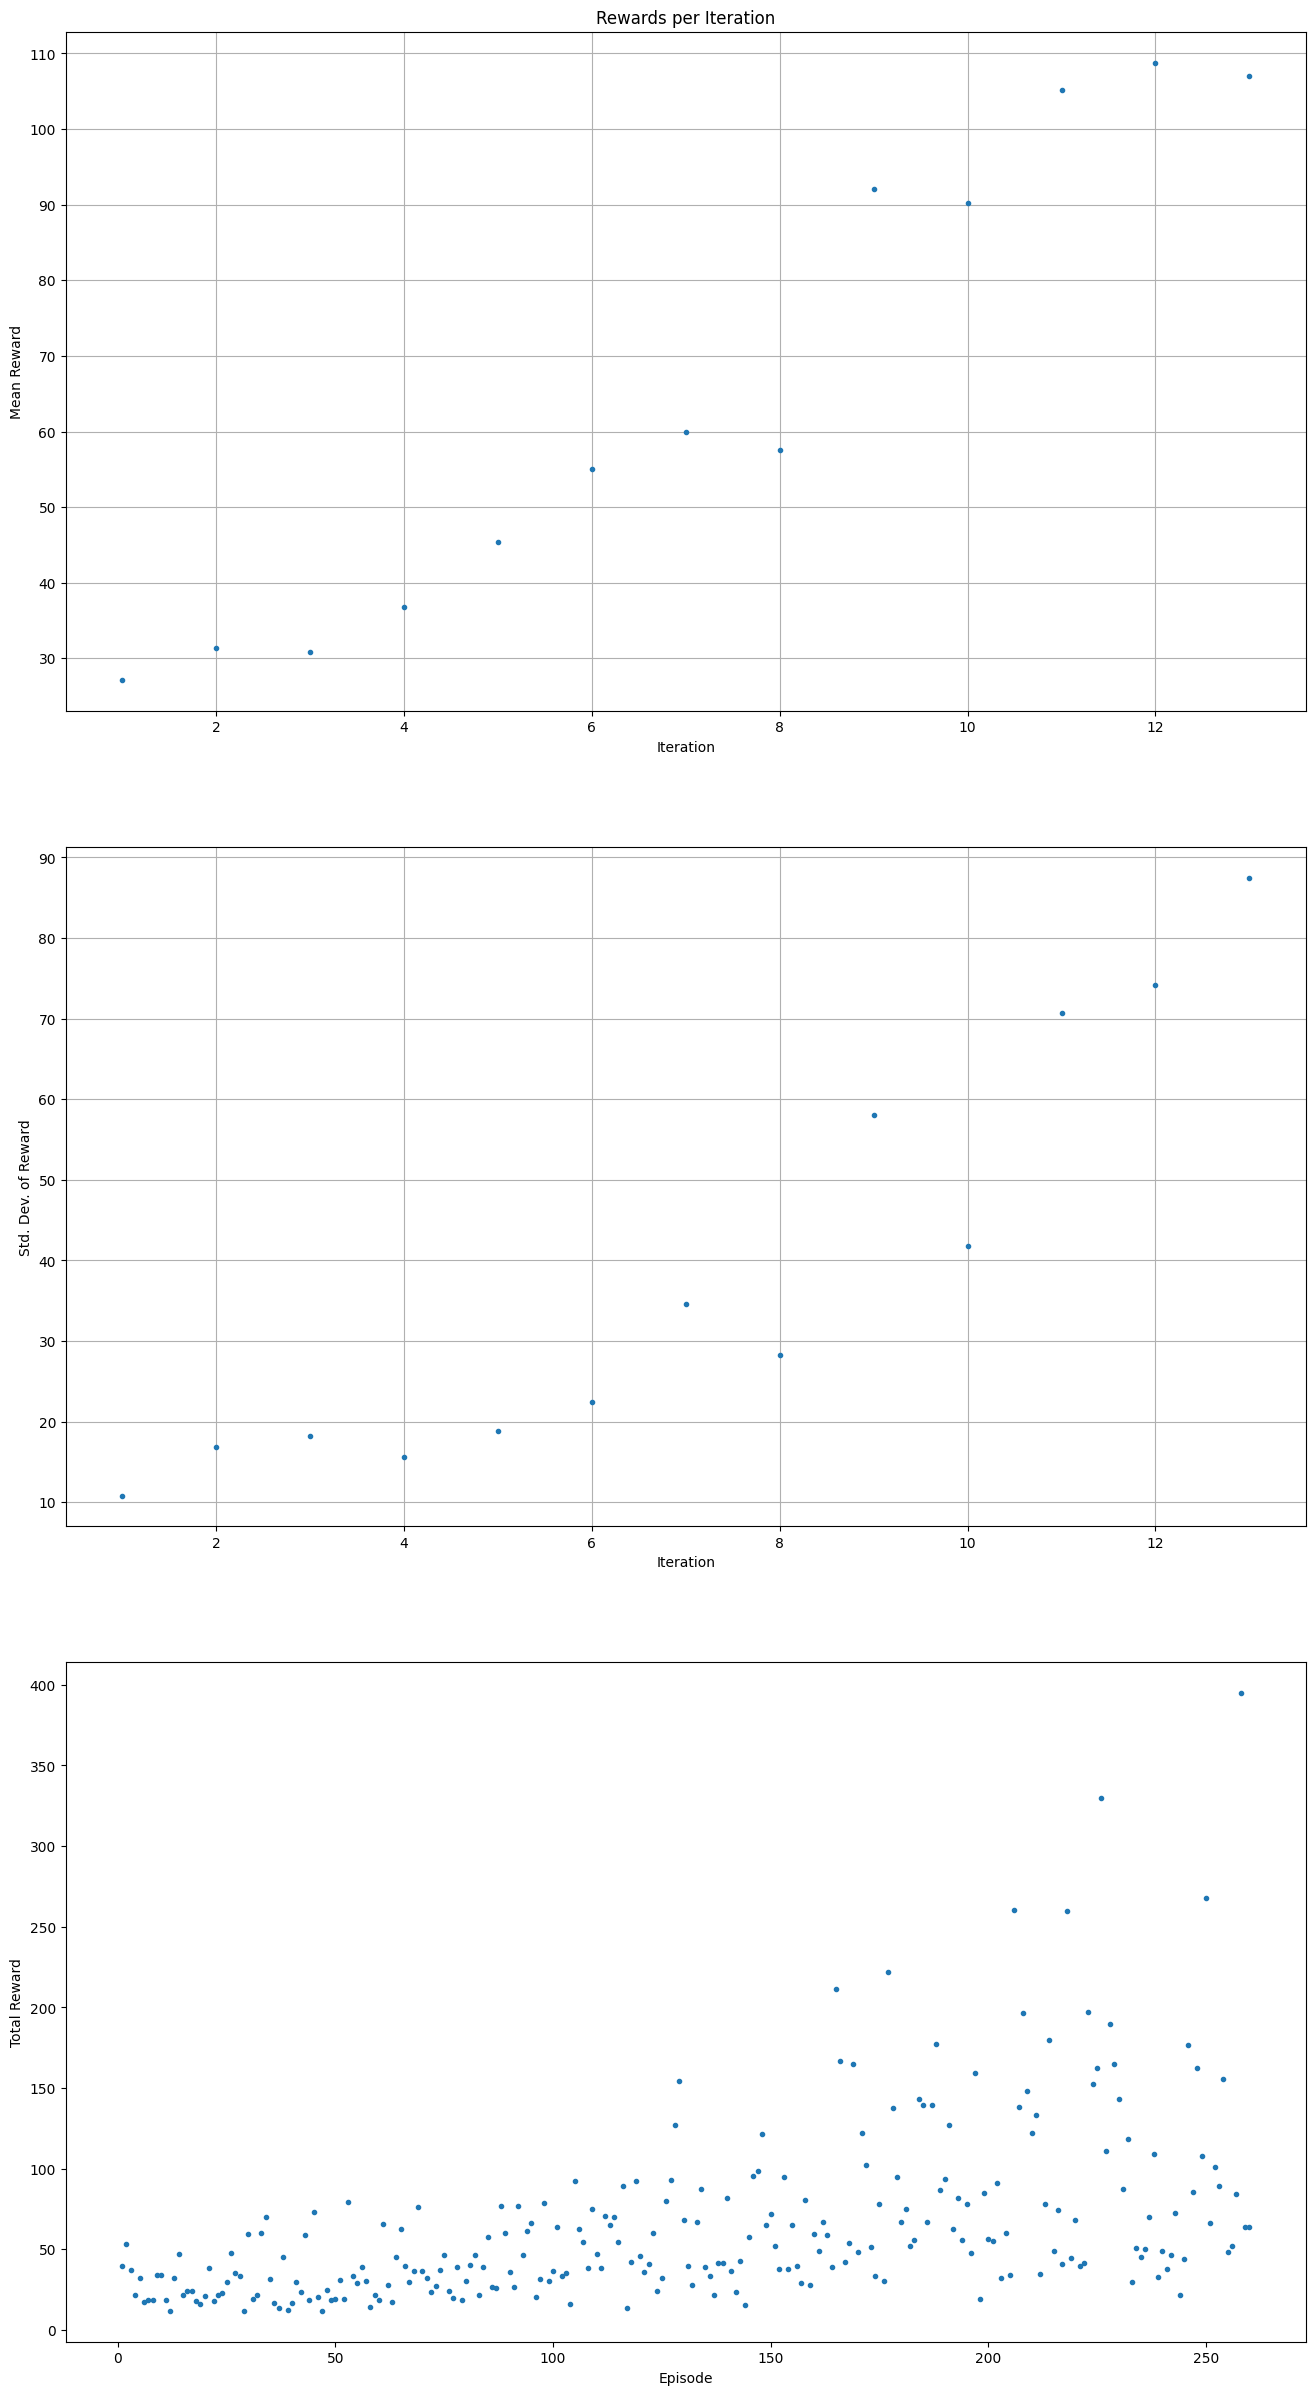

In [20]:
#Reward graph per episode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

max_ep = np.max(sim_df['episode'])
max_iteration = np.max(policytrn_df['iteration']) #tempoary fix 
print('Number of episodes = ', max_ep)
print('Number of complete iterations = ', max_iteration)


# Calculate total rewards per episode
total_rewards = sim_df.groupby('episode')['reward'].sum().values

# Calculate average and standard deviation of rewards per iteration
buffer_rew = []
average_rewards, deviation_rewards = [], []

for idx, reward in enumerate(total_rewards, 1):
    buffer_rew.append(reward)
    if idx % EPI == 0:
        average_rewards.append(np.mean(buffer_rew))
        deviation_rewards.append(np.std(buffer_rew))
        buffer_rew.clear()

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(16, 30))

# Plot average rewards
axes[0].plot(range(1, len(average_rewards) + 1), average_rewards, '.')
axes[0].set(title='Rewards per Iteration', xlabel='Iteration', ylabel='Mean Reward')
axes[0].grid(True)

# Plot standard deviation of rewards
axes[1].plot(range(1, len(deviation_rewards) + 1), deviation_rewards, '.')
axes[1].set(ylabel='Std. Dev. of Reward', xlabel='Iteration')
axes[1].grid(True)

# Plot total rewards
axes[2].plot(range(1, len(total_rewards) + 1), total_rewards, '.')
axes[2].set(ylabel='Total Reward', xlabel='Episode')
axes[2].grid(False)

plt.show()


In [19]:
#Performance Envelope of the Model graph-to do

In [68]:
#Potential Model Checkpoints for Cloning and Race Submission-to do

KeyError: 'total_rewards_SMA3'

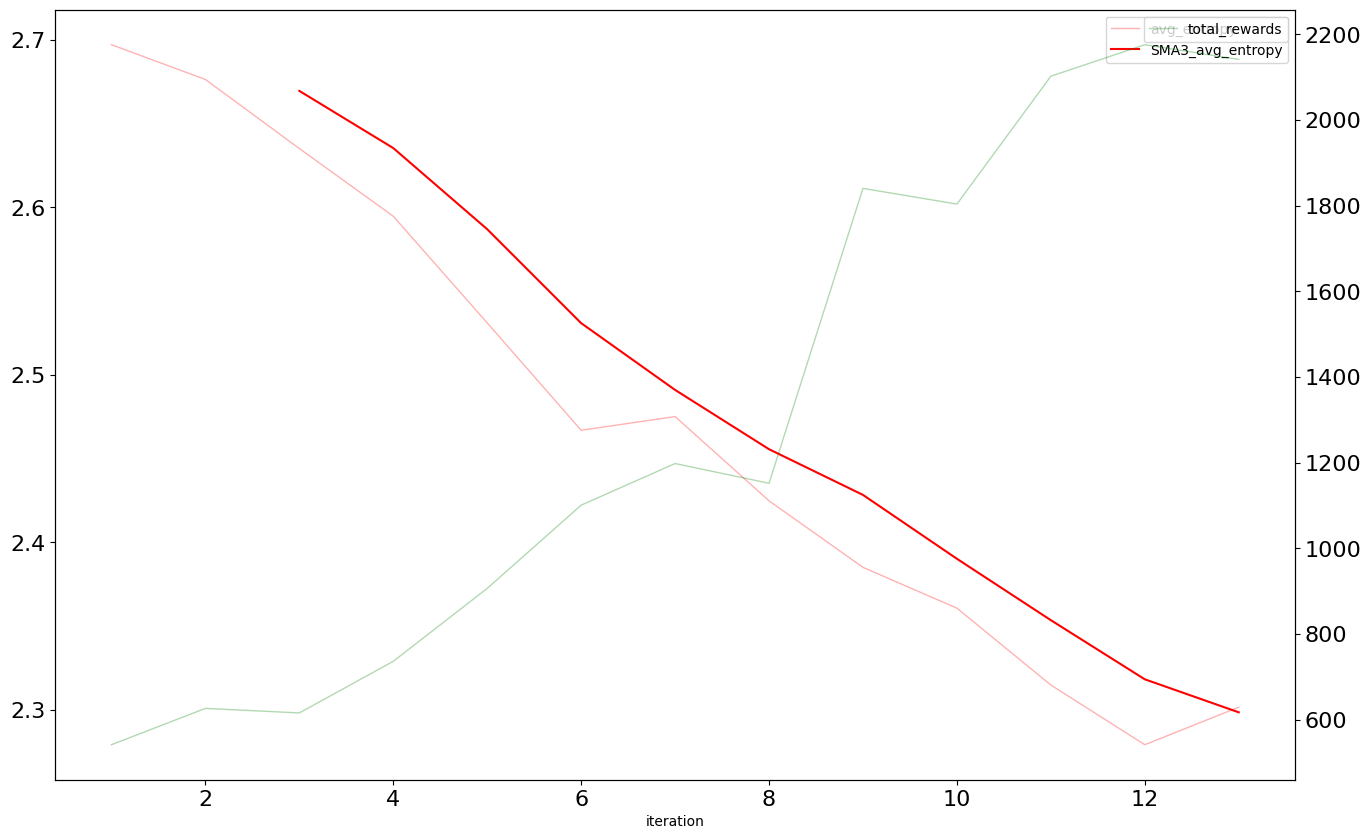

In [21]:
#def reward_graph(df_RELP_iterations=iteration_sim_df, df_RELP_entropy=policytrn_df_entropy)
    #font_size=21


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_line(ax, df, x_col, y_col, **kwargs):
    df.plot(kind='line', x=x_col, y=y_col, ax=ax, **kwargs)

def plot_max_point(ax, df, x_col, y_col, label, font_size):
    max_iter = df[y_col].idxmax()
    if max_iter >= 0:
        x_val, y_val = df.loc[max_iter, [x_col, y_col]]
        ax.axvline(x=x_val, linestyle='dotted', linewidth=0.75, color='black')
        ax.axhline(y=y_val, linestyle='dotted', linewidth=0.75, color='black', alpha=0.3)
        ax.text(x_val * 0.995, y_val * 1.005, f'{label} @ {x_val}', ha='right', va='bottom', size=font_size)

def plot_reward_graph(df_RELP_iterations, df_RELP_entropy):
    if df_RELP_iterations.empty:
        return
    
    font_size = 16
    fig, ax1 = plt.subplots(figsize=(16, 10))
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twinx()
    
    # Plot Entropy
    plot_line(ax1, df_RELP_entropy, 'iteration', 'avg_entropy', linewidth=1, color='red', alpha=0.3, fontsize=font_size)
    plot_line(ax1, df_RELP_entropy, 'iteration', 'SMA3_avg_entropy', linewidth=1.5, color='red', fontsize=font_size)
    
    # Plot Rewards and Progress
    for col, style, color in [('total_rewards', 'solid', 'green'), ('avg_progress', 'dashdot', 'blue')]:
        plot_line(ax2, df_RELP_iterations, 'iteration', col, linewidth=1, color=color, alpha=0.3, fontsize=font_size)
        plot_line(ax2, df_RELP_iterations, 'iteration', f'{col}_SMA3', linestyle=style, linewidth=1.5, color=color, fontsize=font_size)
        
    # Add text and lines for max points
    plot_max_point(ax2, df_RELP_iterations, 'iteration', 'normalized_total_rewards_SMA3', 'Max Rewards', font_size)
    plot_max_point(ax2, df_RELP_iterations, 'iteration', 'avg_progress_SMA3', 'Max Progress', font_size)
    
    ax1.set_xlabel('Iteration', fontsize=font_size)
    ax1.set_ylabel('Entropy', fontsize=font_size)
    ax2.set_ylabel('Normalized Rewards / Progress (%)', fontsize=font_size)

    plt.yticks(np.arange(0, 105, step=10))
    plt.show()

# Call the function
plot_reward_graph(iteration_sim_df, policytrn_df_entropy)

In [30]:
import numpy as np
import os
import re

def find_matching_track_file(world_name):
    track_folder_path = "./Tracks"  
    for filename in os.listdir(track_folder_path):
        if world_name.lower() in filename.lower() and filename.endswith('.npy'):
            return filename
    return None

def get_track_checkpoints(track_filename):
    track_path = os.path.join("./Tracks", track_filename)
    return np.load(track_path)

def get_track_name_from_log(robomaker_log, line_number=228):
    with open(robomaker_log, 'r') as file:
        for i, line in enumerate(file, 1):
            if i == line_number:
                match = re.search(r"Topic \[(.*?)//", line)
                if match:
                    return match.group(1)
    return None



track_name = get_track_name_from_log(robomaker_log)

if track_name:
    matching_track_file = find_matching_track_file(track_name)
    if matching_track_file:
        checkpoints = get_track_checkpoints(matching_track_file)
        print(f"Found matching track file: {matching_track_file}")
        print(f"checkpoints shape: {checkpoints.shape}")
    else:
        print("No matching track file found.")
else:
    print("Track name not found in log.")


Found matching track file: reInvent2019_track_ccw.npy
checkpoints shape: (79, 6)


No matching track file found.


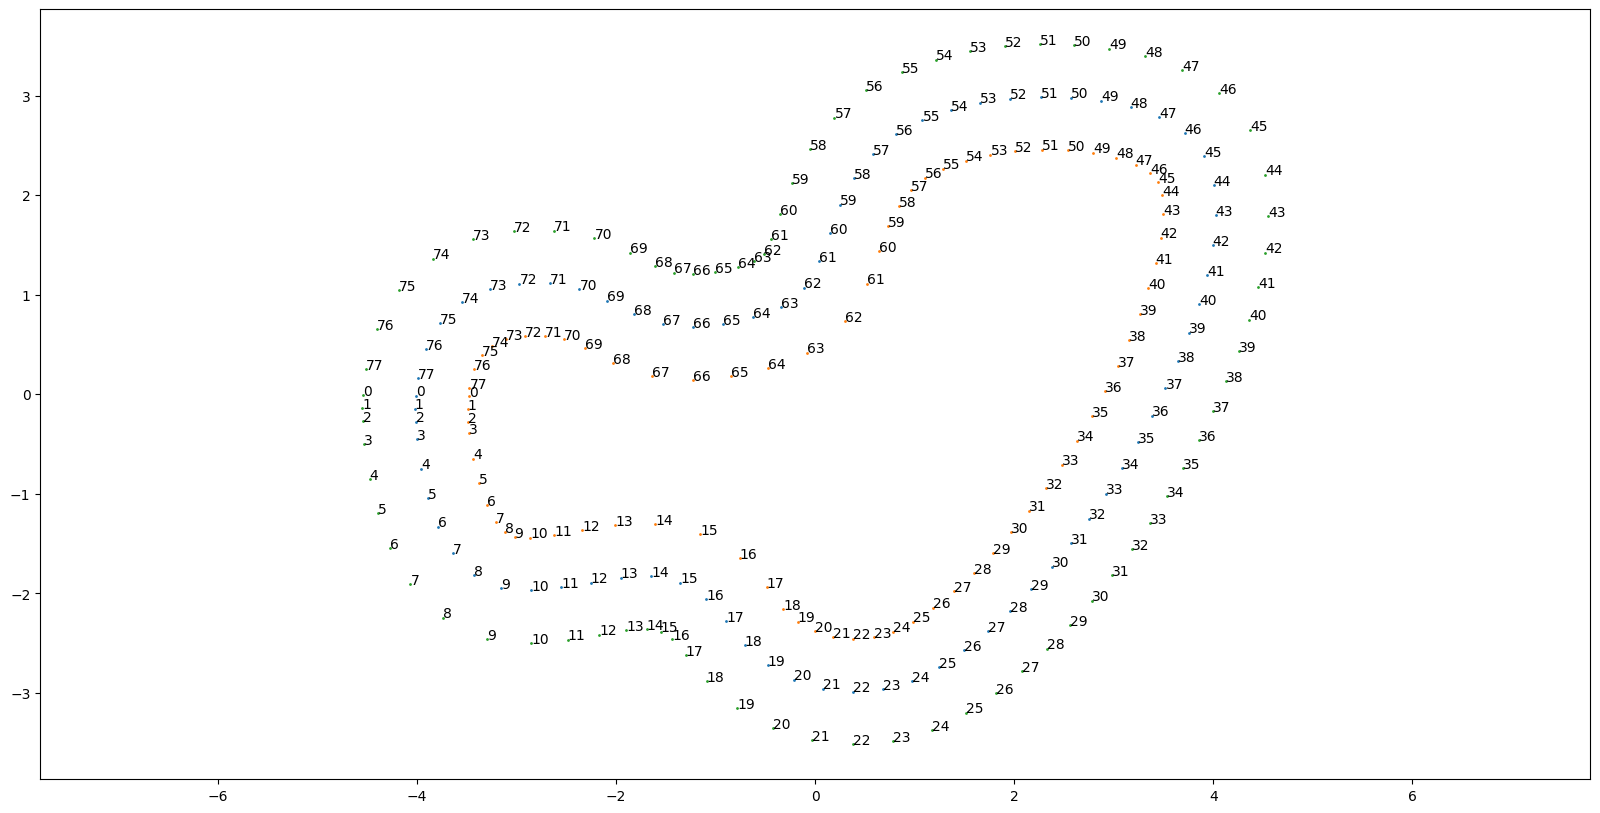

In [31]:
import matplotlib.pyplot as plt

def plot_points(ax, points):
    ax.scatter(points[:,0], points[:,1], s=1)
    for i, p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

# Plot the results
fig, ax = plt.subplots(figsize=(20, 10))
plot_points(ax, checkpoints[:-1, 0:2])
plot_points(ax, checkpoints[:-1, 2:4])
plot_points(ax, checkpoints[:-1, 4:6])
ax.axis('equal')
plt.show()


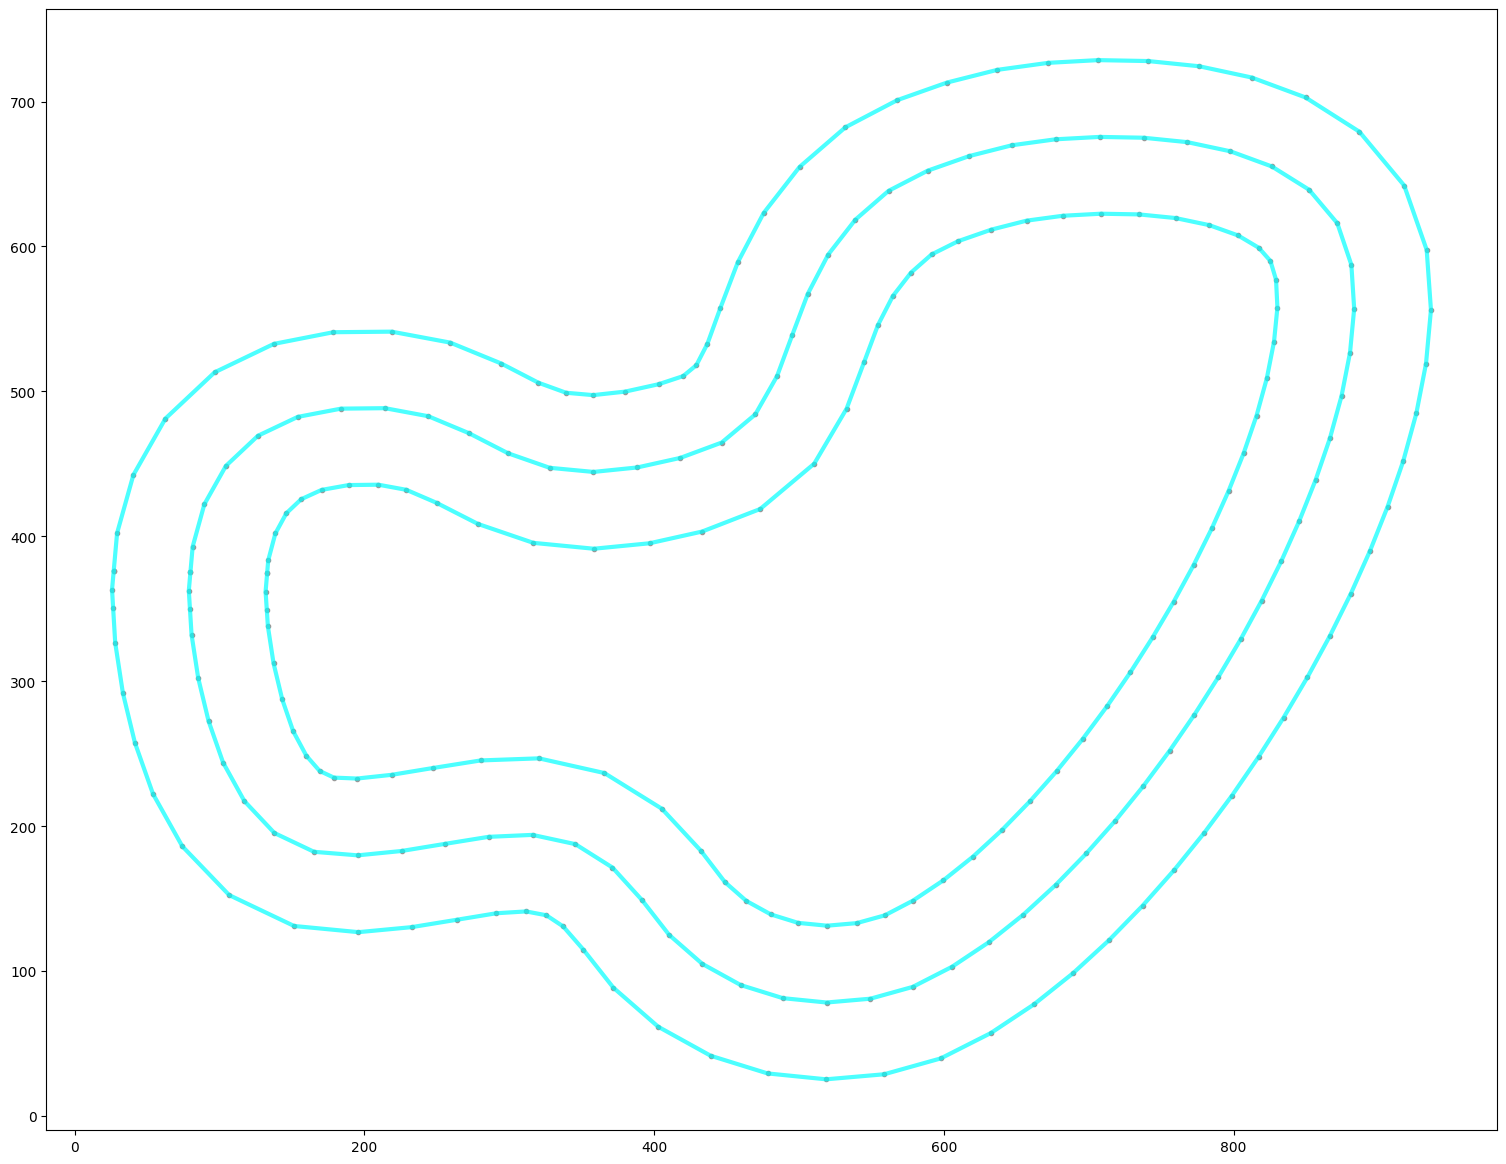

In [32]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# rescale to centimeter 
center_line = checkpoints[:, 0:2] * 100
inner_border = checkpoints[:, 2:4] * 100
outer_border = checkpoints[:, 4:6] * 100

# Adjust for x_offset and y_offset
x_offset = abs(min(0, int(sim_df['x'].min())))
y_offset = abs(min(0, int(sim_df['y'].min())))

# Add offsets 
inner_border += [x_offset, y_offset]
center_line += [x_offset, y_offset]
outer_border += [x_offset, y_offset]


def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, checkpoints, inner_border_checkpoints, outer_border_checkpoints):
    line = LineString(checkpoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_checkpoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_checkpoints)
    plot_coords(ax, line)
    plot_line(ax, line)

# plot dimensions on checkpoints data
plot_x_max = int(max(np.max(outer_border[:, 0]), np.max(center_line[:, 0]), np.max(inner_border[:, 0])))
plot_y_max = int(max(np.max(outer_border[:, 1]), np.max(center_line[:, 1]), np.max(inner_border[:, 1])))

fig = plt.figure(figsize=(plot_x_max / 50, plot_y_max / 50))
ax = fig.add_subplot(111)
print_border(ax, center_line, inner_border, outer_border)


In [34]:
def plot_arrow(ax, x, y, dx, dy, color):
    ax.arrow(x, y, dx, dy, linewidth=1, head_width=8, head_length=5, fc=color, ec=color, zorder=99)

def plot_episode_info(ax, episode):
    title = f"Episode: {episode['episode']} (Iteration: {episode['iteration']}, Episode-in-Iteration: {episode['EPI(now working)']})"
    title += f", Steps: {episode['steps']}, Progress: {episode['progress']}, Rewards: {episode['episode_total_rewards']}, Elapsed Time: {episode['elapsed_time']}, Status: {episode['status']}"

    ax.set_title(title)

def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig, axes = plt.subplots(n_laps, 1, figsize=(plot_x_max/50, plot_y_max/50 * n_laps))
    if n_laps == 1:
        axes = [axes]  # Make it iterable
    for i, ax in enumerate(axes):
        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode'] == idx]
        episode_info = episode_sim_df[episode_sim_df['episode'] == idx].iloc[0]
        
        plot_episode_info(ax, episode_info)
        print_border(ax, center_line, inner_border, outer_border)
        
        for _, row in episode_data.iterrows():
            x, y = row['x'] + x_offset, row['y'] + y_offset
            ax.plot([x, x-0.02+x_offset], [y, y+y_offset], 'b.')
            
            if plot_yaw:
                dx = 5 * row['speed'] * math.cos(math.radians(row['yaw']))
                dy = 5 * row['speed'] * math.sin(math.radians(row['yaw']))
                plot_arrow(ax, x, y, dx, dy, 'b')
            
            if plot_steer:
                dx = 5 * row['speed'] * math.cos(math.radians(row['yaw'] + row['steer']))
                dy = 5 * row['speed'] * math.sin(math.radians(row['yaw'] + row['steer']))
                color = 'r' if row['steer'] < 0 else 'lime' if row['steer'] > 0 else 'y'
                plot_arrow(ax, x, y, dx, dy, color)

            if plot_labels:
                label_txt = f"STP: {row['steps']}, WP: {row['closest_checkpoint']}, HD: {row['yaw']:.2f}, STR: {row['steer']}, THR: {row['speed']}"
                ax.text(x, y, label_txt)
                print(label_txt)

        
        
    episode_data_dict = episode_data.to_dict(orient='records')
    episode_info_dict = episode_info.to_dict()

    # Combine into one data object
    processed_data = {
            'episode_data': episode_data_dict,
            'episode_info': episode_info_dict,
            'n_laps': n_laps,
            'x_offset': x_offset,
            'y_offset': y_offset,
            'plot_yaw': plot_yaw,
            'plot_steer': plot_steer,
            'plot_labels': plot_labels
        }

    # Add processed_data to Firebase
    doc_ref = db.collection('processed_data_collection').add(processed_data)



        


    

    return fig

# Usage
episode_sim_df_fastest_full_lap = episode_sim_df[episode_sim_df['progress'] >= 100.0].sort_values('elapsed_time').head(1)
if len(episode_sim_df_fastest_full_lap) > 0:
    fig = plot_top_laps(episode_sim_df_fastest_full_lap['episode'].values, len(episode_sim_df_fastest_full_lap), x_offset, y_offset)


# Upload Data
if len(episode_sim_df_fastest_full_lap) > 0:
    for episode in episode_sim_df_fastest_full_lap.iterrows():
        episode_info = episode[1]
        episode_summary = {
            'episode': episode_info['episode'],
            'iteration': episode_info['iteration'],
            'steps': episode_info['steps'],
            'progress': episode_info['progress'],
            'rewards': episode_info['episode_total_rewards'],
            'elapsed_time': episode_info['elapsed_time'],
            'status': episode_info['status']
        }
        doc_ref = db.collection('episode_summaries').add(episode_summary)



In [35]:

if episode_sim_df_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(episode_sim_df_fastest_full_lap['episode'].values, 
                        len(episode_sim_df_fastest_full_lap), 
                        x_offset, 
                        y_offset, 
                        True, 
                        True)
    
    #Zoom in for better look
    for ax in fig.get_axes():
        episode_id = episode_sim_df_fastest_full_lap['episode'].values[0]
        episode_data = sim_df[sim_df['episode'] == episode_id]
        min_x, max_x = episode_data['x'].min(), episode_data['x'].max()
        min_y, max_y = episode_data['y'].min(), episode_data['y'].max()
        
        ax.set_xlim([min_x, max_x])
        ax.set_ylim([min_y, max_y])



#Blue is the HEADING of the car
#Green shows that the car is turning left
#Yellow shows that the car is driving straight
#Red shows that the car is turning right
#The length of each arrow indicates the relative speed of the car


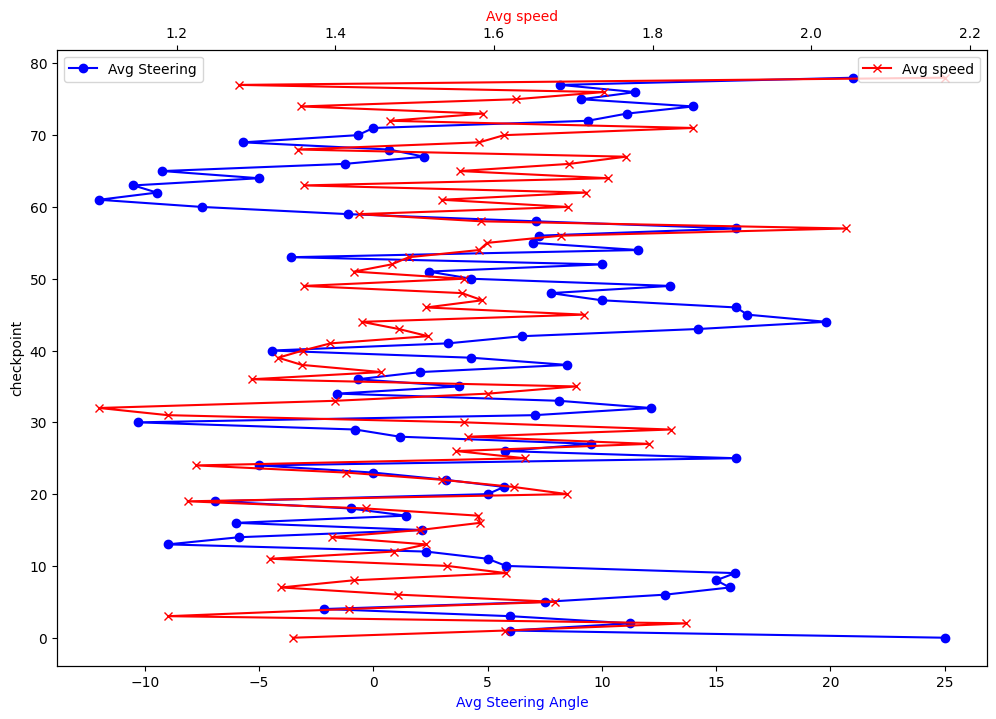

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_avg_speed_steering(df):
    # Group data by checkpoint and calculate mean
    grouped_df = df.groupby('closest_checkpoint').agg({'steer': 'mean', 'speed': 'mean'}).reset_index()

    # Create a plot
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax2 = ax1.twiny()
    
    ax1.plot(grouped_df['steer'], grouped_df['closest_checkpoint'], 'bo-', label='Avg Steering')
    ax2.plot(grouped_df['speed'], grouped_df['closest_checkpoint'], 'rx-', label='Avg speed')
    
    ax1.set_xlabel('Avg Steering Angle', color='b')
    ax2.set_xlabel('Avg speed', color='r')
    
    ax1.set_ylabel('checkpoint')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.show()


max_iteration = sim_df['iteration'].max()
plot_avg_speed_steering(sim_df[sim_df['iteration'] == max_iteration])
